In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("../..")
from common.utils import timestep_csv_names

import numpy as np


def calc_u_v(df, ob_point):
    wind_dir = float(df["WD1"])
    wind_speed = float(df["WS1"])

    rads = np.radians(float(wind_dir))
    wind_u, wind_v = -1 * wind_speed * np.cos(rads), -1 * wind_speed * np.sin(rads)
    # wind_u_v = wind_components(wind_speed * units("m/s"), wind_dir * units.deg)

    return [
        ob_point,
        round(wind_u, 5),
        round(wind_v, 5),
    ]  # (index, u wind, v wind) u: X (East-West) v: Y(North-South)

In [2]:
import os
root_dir = "../../../data/one_day_data/"
assert os.path.exists(root_dir)

In [21]:
year = "2020"
month = "10"
date = "2020-10-12"
timesteps = ["6:00", "6:10", "6:20", "6:30", "6:40", "6:50", "7:00", "7:10", "7:20", "7:30", "7:40", "7:50"]
target_cols = ["hour-rain", "AT1", "RH1", "WS1", "V-Wind", "U-Wind", "PRS", "Time", "Station_Name"]
df = pd.DataFrame(columns=target_cols)
for time in timesteps:
    parquet_file = time.replace(":", "-").replace("00", "0")
    parquet_file += ".parquet.gzip"
    file_path = os.path.join(root_dir, year, month, date, parquet_file)
    _df = pd.read_parquet(file_path, engine="pyarrow")
    _df["Station_Name"] = _df['Unnamed: 0']
    _df["Time"] = time
    wind_df = pd.DataFrame([calc_u_v(_df.loc[i, :], i) for i in _df.index], columns=["OB-Point", "U-Wind", "V-Wind"])
    _df["V-Wind"], _df["U-Wind"] = wind_df["V-Wind"], wind_df["U-Wind"]
    df = df.append(_df[target_cols], ignore_index=True)

In [22]:
df.head()

,hour-rain,AT1,RH1,WS1,V-Wind,U-Wind,PRS,Time,Station_Name
0,0.0,31.1,51.3,0.4,0.39903,0.02790,1004.4,6:00,Vlz-Bagbaguin_00174731
1,0.0,32.6,51.1,0.2,0.14863,-0.13383,1001.6,6:00,NagNayon_00181273
2,0.0,31.2,53.0,0.2,0.04158,0.19563,1004.6,6:00,DLSAU_00174722
3,0.0,31.5,50.4,1.4,1.11809,-0.84254,999.4,6:00,ASTI_00173457
4,0.0,32.2,50.3,1.4,-0.00000,1.40000,1005.3,6:00,MM-SanAndres_00173459


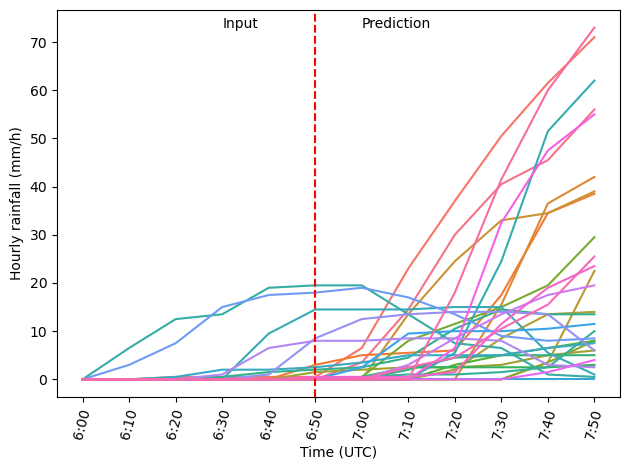

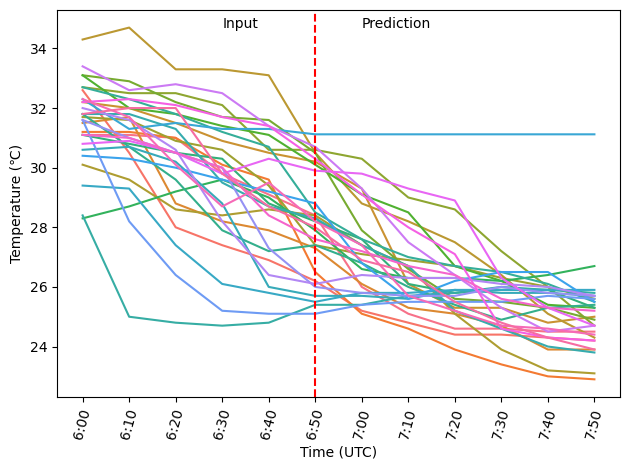

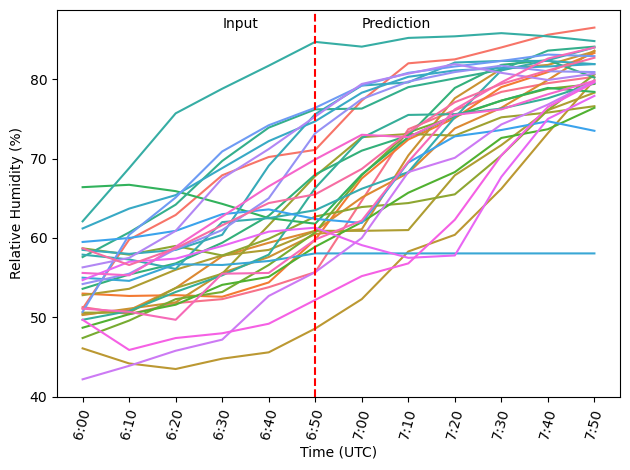

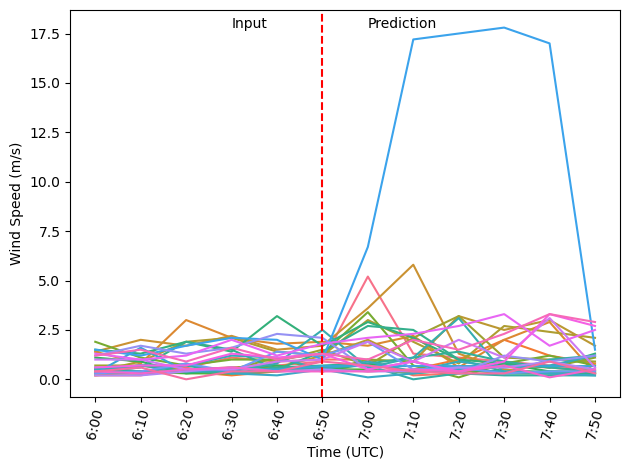

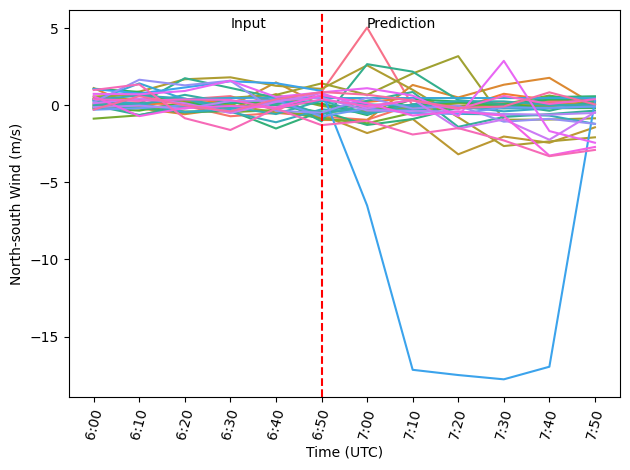

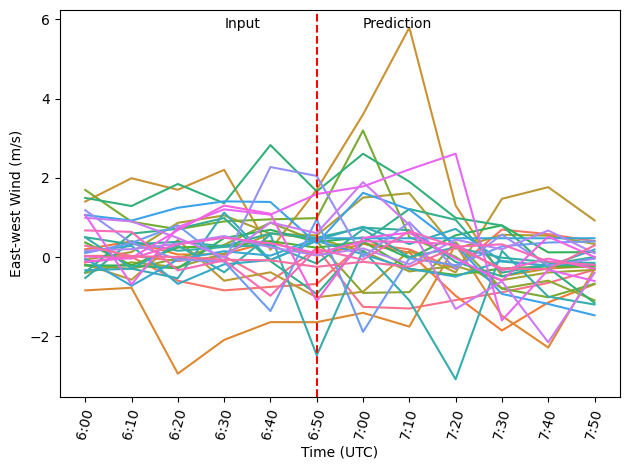

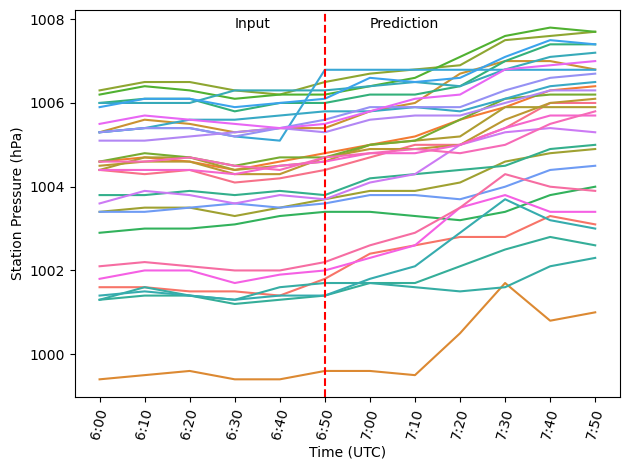

In [63]:
target_cols = ["hour-rain", "AT1", "RH1", "WS1", "V-Wind", "U-Wind", "PRS"]
target_labels = ["Hourly rainfall (mm/h)", "Temperature (℃)", "Relative Humidity (%)", "Wind Speed (m/s)", "North-south Wind (m/s)", "East-west Wind (m/s)", "Station Pressure (hPa)"]
exclude_station_name = ["MM-EFCOS_00173456"]
for idx, col in enumerate(target_cols):
    if col != "Station_Name":
        _target_df = df[[col, "Time", "Station_Name"]]
        _target_df = _target_df.loc[(_target_df["Station_Name"] != exclude_station_name[0])]
        ax = sns.lineplot(data=_target_df, x="Time", y=col, hue="Station_Name")
        plt.axvline(x="6:50", color="r", linestyle="--")
        ax.set_ylabel(target_labels[idx])
        ax.set_xlabel("Time (UTC)")
        ax.text(x="6:30", y=_target_df[col].max(), s="Input")
        ax.text(x="7:00", y=_target_df[col].max(), s="Prediction")
        ax.get_legend().remove()
        plt.xticks(rotation=75)
        plt.tight_layout()
        plt.savefig(f"{col}.png")
        plt.show()
        plt.close()

In [57]:
bad_df = df.loc[df["Station_Name"] == "MM-EFCOS_00173456"]
bad_df

,hour-rain,AT1,RH1,WS1,V-Wind,U-Wind,PRS,Time,Station_Name,diff
17,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,6:00,MM-EFCOS_00173456,NaN
48,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,6:10,MM-EFCOS_00173456,0.0
79,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,6:20,MM-EFCOS_00173456,0.0
110,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,6:30,MM-EFCOS_00173456,0.0
141,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,6:40,MM-EFCOS_00173456,0.0
172,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,6:50,MM-EFCOS_00173456,0.0
203,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,7:00,MM-EFCOS_00173456,0.0
234,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,7:10,MM-EFCOS_00173456,0.0
265,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,7:20,MM-EFCOS_00173456,0.0
296,0.0,24.89375,81.25,5.79375,-3.74348,4.42198,1008.4625,7:30,MM-EFCOS_00173456,0.0
